In [249]:
import numpy as np

In [250]:
import scipy.stats as sts
import heapq
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

from collections import deque
import numpy as np

#adapt the code from classes 
class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    '''
    
    def __init__(self):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')

In [251]:
class TrafficLight: 
    def __init__(self, time_step = 2): 
        """
        Create a traffic light object that can switch lights
        """
        self.traffic_light = '🟢'
        self.time_step = time_step
        
    def run(self, schedule): 
        """
        Start with a green light 

        Parameters
        ----------
        schedule: Schedule
            A schedule object associated with the simulation

        Returns
        ----------
        None   
        """
        if self.traffic_light == '🟢':
            schedule.add_event_after(self.time_step, self.change_to_red)
        else: 
            schedule.add_event_after(self.time_step, self.change_to_green)

    def change_to_red(self, schedule): 
        """
        Schedule a red light 

        Parameters
        ----------
        schedule: Schedule
            A schedule object associated with the simulation

        Returns
        ----------
        None           
        """
        self.traffic_light = '🔴'
        schedule.add_event_after(self.time_step, self.change_to_green)

    def change_to_green(self, schedule): 
        """
        Schedule a green light 
        
        Parameters
        ----------
        schedule: Schedule
            A schedule object associated with the simulation

        Returns
        ----------
        None           
        """        
        self.traffic_light = '🟢'
        schedule.add_event_after(self.time_step, self.change_to_red)


In [252]:
class Road: 
    def __init__(self, road_length, direction, TrafficLight): 
        self.road_list = [-1 for _ in range(road_length)]
        self.direction = direction
        self.road_length = road_length
        self.next_road = None 
        self.next_road_intersection_loc = float('inf')
        self.prev_road = None 
        self.prev_road_intersection_loc = float('inf')        
        self.reg_traffic_light_loc = None 
        self.turn_traffic_light_loc = None 
        self.light_object = TrafficLight


    def update_next_road(self, road, intersection): 
        """
        Find the next road of the current road and their intersection 
        
        Parameters
        ----------
        road: object
            Current road 
        intersection: int
            The location of the intersection

        Returns
        ----------
        None           
        """        
        self.next_road = road
        self.next_road_intersection_loc = intersection
    
    def update_prev_road(self, road, intersection): 
        """
        Find the previous road of the current road and their intersection 
        
        Parameters
        ----------
        road: object
            Current road 
        intersection: int
            The location of the intersection

        Returns
        ----------
        None           
        """                
        self.prev_road = road
        self.prev_road_intersection_loc = intersection

    def update_traffic_light(self): 
        """
        Update traffic light on the roads
        
        Parameters
        ----------
        None

        Returns
        ----------
        None           
        """                        
        one_light = self.light_object.traffic_light 
        
        if one_light == '🔴': other_light = '🟢'
        else: other_light = '🔴'

        if (self.direction == 'up'): 
            self.turn_traffic_light_loc = 3 + 1
            self.reg_traffic_light_loc = self.road_length - 3
            self.road_list[self.reg_traffic_light_loc] = one_light
            self.road_list[self.turn_traffic_light_loc] = one_light
        if (self.direction == 'right') : 
            self.turn_traffic_light_loc = 3 + 1
            self.reg_traffic_light_loc = self.road_length - 3
            self.road_list[self.reg_traffic_light_loc] = other_light
            self.road_list[self.turn_traffic_light_loc] = other_light
    
        if self.direction == 'left':
            self.reg_traffic_light_loc = 3 - 1
            self.turn_traffic_light_loc = self.road_length - 5 
            self.road_list[self.reg_traffic_light_loc] = other_light
            self.road_list[self.turn_traffic_light_loc] = other_light            
        if self.direction == 'down': 
            self.reg_traffic_light_loc = 3 - 1
            self.turn_traffic_light_loc = self.road_length - 5  
            self.road_list[self.reg_traffic_light_loc] = one_light
            self.road_list[self.turn_traffic_light_loc] = one_light   


In [262]:

class TrafficSimulation: 
    def __init__(self, TrafficLight, car_density, road_length, max_speed, car_turn_prob, prob_slow, system_time_step = 1): 
        self.car_density = car_density
        self.road_length = road_length
        self.v_roads = [Road(self.road_length, 'up', TrafficLight), Road(self.road_length, 'down', TrafficLight)]
        self.h_roads = [Road(self.road_length, 'left', TrafficLight), Road(self.road_length, 'right', TrafficLight)]
        self.max_speed = max_speed
        self.time_step = 0 
        self.light_object = TrafficLight
        self.car_turn_prob = car_turn_prob
        self.prob_slow = prob_slow
        self.system_time_step = system_time_step

        # Keep track of the time steps and average traffic flow at each step
        self.time_step = 0
        self.average_traffic_flow = []


       # Create an empty road: -1 means empty in this simulation
        self.state = np.matrix([['▊' for _ in range(self.road_length)] for _ in range(self.road_length)])

        self.place_car_on_road(self.v_roads)
        self.place_car_on_road(self.h_roads)
        # self.add_traffic_light()                
        self.place_road_on_grid()
        # print("⭐⭐", self.state)


    def place_car_on_road(self, roads): 
       for road in roads: 
            # Choose random locations to place cars
            random_indexes = np.random.choice(
                range(self.road_length),
                size=int(round(self.car_density * self.road_length)),
                replace=False)
            # print("random_indexes", random_indexes)

            #no car in the intersection in the beginning 
            intersection = set([3, self.road_length-4])
            random_indexes = list(set(random_indexes) - intersection)

            # Give each car a random initial speed from 0 to max_speed
            for x in random_indexes: 
                speed = np.random.randint(0, self.max_speed)
                road.road_list[x] = speed     
        
   
    def place_road_on_grid(self): 
        roads = self.h_roads + self.v_roads
        h_0 = self.h_roads[0]
        h_1 = self.h_roads[1]
        v_0 = self.v_roads[0]
        v_1 = self.v_roads[1]

        self.add_traffic_light()        

        #connect roads and specify interesections for pevious and next road
        v_0.update_next_road(h_0, 3) #v_0's location 3 is the intersection of the next road 
        h_0.update_next_road(v_1, self.road_length-4) 
        v_1.update_next_road(h_1, self.road_length-4)
        h_1.update_next_road(v_0, 3)        
        v_0.update_prev_road(h_1, self.road_length-4)
        h_0.update_prev_road(v_0, 3)        
        v_1.update_prev_road(h_0, 3)
        h_1.update_prev_road(v_1, self.road_length-4)
        
        #car can turn
        for road in roads: 
            self.car_turn(road)
            print('⭐️⭐️  new_road', road.direction, road.road_list)

        # add roads on 2D grid
        self.state[3] = h_0.road_list
        self.state[-4] = h_1.road_list
        self.state[:, 3] = np.reshape(v_0.road_list, (self.road_length, 1))
        self.state[:, -4] = np.reshape(v_1.road_list, (self.road_length, 1)) 
        self.fix_intersection_display(h_0, v_0, h_1, v_1)

    def fix_intersection_display(self, h_0, v_0, h_1, v_1): 
        """
        Fix the intersection point display
        """

        #piece the right intersection - prevent intersection on h_roads get covered
        #pair up index of the same intersection on two roads (use global location)
        left_up_h0, left_up_v0 = h_0.reg_traffic_light_loc + 1, v_0.turn_traffic_light_loc - 1
        right_up_h0, right_up_v1 = h_0.turn_traffic_light_loc + 1, v_1.reg_traffic_light_loc + 1
        right_down_h1, right_down_v1= h_1.reg_traffic_light_loc - 1, v_1.turn_traffic_light_loc + 1
        left_down_h1, left_down_v0= h_1.turn_traffic_light_loc - 1, v_0.reg_traffic_light_loc - 1

        if h_0.road_list[left_up_h0] != -1: 
            self.state[left_up_h0, left_up_v0] = h_0.road_list[left_up_h0]

        if h_0.road_list[right_up_h0] != -1:
            self.state[right_up_h0, right_up_v1] = h_0.road_list[right_up_h0]

        if h_1.road_list[right_down_h1] != -1:
            self.state[right_down_h1, right_down_v1] = h_1.road_list[right_down_h1]

        if h_1.road_list[left_down_h1] != -1:
            self.state[left_down_h1, left_down_v0] = h_1.road_list[left_down_h1]
    
        
    def car_turn(self, road): 

        if road.direction == 'left': 
            turn_intersection_loc = road.road_length - road.turn_traffic_light_loc + 1
            new_turn_intersection_loc = road.road_length - turn_intersection_loc - 1
        elif road.direction == 'down':
            turn_intersection_loc = road.turn_traffic_light_loc + 1
            new_turn_intersection_loc = road.road_length - road.turn_traffic_light_loc + 1
        elif road.direction == 'up':
            turn_intersection_loc = road.turn_traffic_light_loc - 1
            new_turn_intersection_loc = turn_intersection_loc
        elif road.direction == 'right': 
            turn_intersection_loc = road.turn_traffic_light_loc - 1
            new_turn_intersection_loc = road.road_length - road.turn_traffic_light_loc 
        
        #if car is on a intersection 
        if road.road_list[turn_intersection_loc] != -1: 
            if random.random() <= self.car_turn_prob:
                #empty the car and put it on the next road    

                cur_car_speed = road.road_list[turn_intersection_loc]
                print('⭐ ⭐ From road', road.direction, 'turn_intersection_loc', turn_intersection_loc, 'to road', road.next_road.direction, 'new_turn_intersection_loc',new_turn_intersection_loc, 'with a speed', cur_car_speed)
                road.road_list[turn_intersection_loc] =  -1
                
                road.next_road.road_list[new_turn_intersection_loc]= cur_car_speed

    def add_traffic_light(self): 
        #update traffic light location on the road 
        roads = self.v_roads + self.h_roads
        for road in roads:
            road.update_traffic_light()
    
    def update_system(self, schedule):         
        roads = self.v_roads + self.h_roads
        self.v_roads = []
        self.h_roads = []
        for road in roads:
            # print('⭐️⭐️  road list', road.direction, road.road_list)

            # Reverse road list the car flow direction
            if (road.direction == 'up') or (road.direction == 'right'): 
                road.road_list.reverse()

            for i in range(len(road.road_list)): 
                ele = road.road_list[i]

            
                #if it's a traffic light 
                if (ele == '🔴') or (ele == '🟢'): 
                    pass

                #if it's a car, not an empty road 
                elif ele != -1:
                    self.update_car(ele, i, road)
            
            
            #move the car 
            new_road = Road(self.road_length, road.direction, self.light_object)

            for i in range(self.road_length):
                cell = road.road_list[i] 
                
                #if a car 
                if cell != -1 and (cell != '🔴') and (cell != '🟢') :
                    new_loc = (i + cell) % self.road_length 

                    #if the loc was a green light, don't step on it, move back one cell. 
                    if road.road_list[new_loc] == '🟢':
                            new_road.road_list[(i + cell -1) % self.road_length] = cell
                    else: 
                        new_road.road_list[new_loc] = cell            
            
            #reverse the list back
            if (new_road.direction == 'up') or (new_road.direction == 'right'): 
                new_road.road_list.reverse()

            #put the new road in the road lists 
            if (new_road.direction == 'up') or (new_road.direction == 'down'): 
                self.v_roads.append(new_road)
            else: 
                self.h_roads.append(new_road)
            # print('⭐️ new_road', new_road.direction, new_road.road_list)

        #Put the road back to the grid  
        self.state = np.matrix([['▊' for _ in range(self.road_length)] for _ in range(self.road_length)])
        
        self.place_road_on_grid()

        # print()
        print("⭐️ ⭐️ ")
        print(self.state)
        
        #Update average traffic flow history
        ttl_traffic_flow = 0
        for road in roads: 
            ttl_traffic_flow += sum([ele if (isinstance(ele, int) and ele >0) else 0 for ele in road.road_list])
        avg_traffic = ttl_traffic_flow/ (self.road_length*4-4) #average 4 roads
        self.average_traffic_flow.append(avg_traffic)
        self.time_step += 1
        
        schedule.add_event_after(self.system_time_step, self.update_system)



    def update_car(self, ele, i, road): 
            # if it's a car         
                # Distance is the number of empty cells between this car and the
                # next car plus 1
                distance = 1
                
                #if empty or green light and no car on the interesection 
                while (road.road_list[(i + distance) % road.road_length] == -1) \
                or (road.road_list[(i + distance) % road.road_length] == '🟢'):

                    # check if there is a car on intersections that we need to stop
                    if ((i + distance) % road.road_length) == road.turn_traffic_light_loc: 
                        if road.road_list[road.next_road_intersection_loc] != -1: 
                            break

                    if ((i + distance) % road.road_length) == road.reg_traffic_light_loc: 
                        if road.road_list[road.prev_road_intersection_loc] != -1: 
                            break
                    distance += 1
                
                # Acceleration
                if road.road_list[i] < self.max_speed:
                    road.road_list[i] += 1
                # Deceleration
                if road.road_list[i] >= distance:
                    road.road_list[i] = distance - 1
                #Randomization
                if (
                    (road.road_list[i] > 0) and
                    (np.random.uniform() < self.prob_slow) #probability of slow 
                ):
                    road.road_list[i] -= 1    


    def run(self, schedule): 
        schedule.add_event_after(2, self.update_system)


## Code testing: no turning and no slowing down

Traffic light: change color for every 2 time steps
System: update every time step

In [263]:
traffic_light = TrafficLight()
schedule = Schedule()
traffic_light.run(schedule)
car_density = 0.5
road_length = 10 
max_speed = 5 
car_turn_prob = 0
prob_slow = 0 

sim = TrafficSimulation(traffic_light, car_density, road_length, max_speed, car_turn_prob, prob_slow)
sim.run(schedule)
while schedule.next_event_time() < 7:
    schedule.run_next_event()

⭐️⭐️  new_road left [1, -1, '🔴', -1, 1, '🔴', -1, -1, -1, 4]
⭐️⭐️  new_road right [-1, -1, 1, -1, '🔴', 1, -1, '🔴', -1, -1]
⭐️⭐️  new_road up [1, 4, 0, -1, '🟢', -1, -1, '🟢', 2, -1]
⭐️⭐️  new_road down [1, -1, '🟢', -1, 3, '🟢', -1, 1, -1, -1]
⭐️⭐️  new_road left [-1, 1, '🟢', -1, 0, '🟢', -1, -1, -1, 0]
⭐️⭐️  new_road right [2, -1, -1, -1, '🟢', 0, -1, '🟢', -1, -1]
⭐️⭐️  new_road up [-1, 0, 0, -1, '🔴', 3, -1, '🔴', -1, 1]
⭐️⭐️  new_road down [-1, 2, '🔴', -1, -1, '🔴', 2, -1, -1, 2]
⭐️ ⭐️ 
[['▊' '▊' '▊' '-' '▊' '▊' '-' '▊' '▊' '▊']
 ['▊' '▊' '▊' '0' '▊' '▊' '2' '▊' '▊' '▊']
 ['▊' '▊' '▊' '0' '▊' '▊' '🔴' '▊' '▊' '▊']
 ['-' '1' '🟢' '-' '0' '🟢' '-' '-' '-' '0']
 ['▊' '▊' '▊' '🔴' '▊' '▊' '-' '▊' '▊' '▊']
 ['▊' '▊' '▊' '3' '▊' '▊' '🔴' '▊' '▊' '▊']
 ['2' '-' '-' '-' '🟢' '0' '2' '🟢' '-' '-']
 ['▊' '▊' '▊' '🔴' '▊' '▊' '-' '▊' '▊' '▊']
 ['▊' '▊' '▊' '-' '▊' '▊' '-' '▊' '▊' '▊']
 ['▊' '▊' '▊' '1' '▊' '▊' '2' '▊' '▊' '▊']]
⭐️⭐️  new_road left [1, -1, '🟢', 2, 1, '🟢', -1, -1, -1, -1]
⭐️⭐️  new_road right [-1

## Code testing for turning function: always turning but no slowing down

(Note: Feel free to use the print function with ⭐️ to test the code.)

In [255]:
traffic_light = TrafficLight()
schedule = Schedule()
traffic_light.run(schedule)
car_density = 0.5
road_length = 10 
max_speed = 5 
car_turn_prob = 1
prob_slow = 0 

sim = TrafficSimulation(traffic_light, car_density, road_length, max_speed, car_turn_prob, prob_slow)
sim.run(schedule)
while schedule.next_event_time() < 7:
    schedule.run_next_event()

⭐️⭐️  new_road left [-1, 2, '🔴', -1, -1, '🔴', -1, -1, 4, 2]
⭐️⭐️  new_road right [1, 0, -1, -1, '🔴', -1, -1, '🔴', 3, 3]
⭐️⭐️  new_road up [-1, -1, -1, -1, '🟢', -1, -1, '🟢', 0, 4]
⭐️⭐️  new_road down [-1, 2, '🟢', -1, 3, '🟢', -1, 4, -1, 2]
⭐️⭐️  new_road left [1, 0, '🟢', -1, -1, '🟢', -1, -1, 0, -1]
⭐️⭐️  new_road right [0, 0, -1, -1, '🟢', -1, -1, '🟢', 0, 0]
⭐️⭐️  new_road up [-1, -1, -1, -1, '🔴', -1, -1, '🔴', 1, 0]
⭐️⭐️  new_road down [1, -1, '🔴', 2, -1, '🔴', -1, -1, 1, -1]
⭐️⭐️  new_road left [0, 1, '🟢', -1, -1, '🟢', -1, -1, -1, 1]
⭐️⭐️  new_road right [0, 0, -1, -1, '🟢', -1, 0, '🟢', 1, 0]
⭐️⭐️  new_road up [-1, -1, -1, -1, '🔴', -1, -1, '🔴', 0, 0]
⭐️⭐️  new_road down [-1, 1, '🔴', -1, 1, '🔴', -1, -1, -1, 1]
⭐️⭐️  new_road left [0, -1, '🔴', 2, -1, '🔴', -1, -1, -1, 0]
⭐️⭐️  new_road right [0, 0, -1, -1, '🔴', -1, 0, '🔴', 1, 0]
⭐️⭐️  new_road up [-1, -1, -1, -1, '🟢', -1, -1, '🟢', 0, 0]
⭐️⭐️  new_road down [1, 0, '🟢', -1, 0, '🟢', -1, -1, -1, -1]
⭐️⭐️  new_road left [-1, 1, '🔴', -1, 1, '🔴', -1

In [256]:
traffic_time_step = 50
traffic_light = TrafficLight(traffic_time_step)
schedule = Schedule()
traffic_light.run(schedule)
car_density = 0.5
road_length = 10 
max_speed = 5 
car_turn_prob = 1
prob_slow = 0 

sim = TrafficSimulation(traffic_light, car_density, road_length, max_speed, car_turn_prob, prob_slow)
sim.run(schedule)
while schedule.next_event_time() < 7:
    schedule.run_next_event()

⭐️⭐️  new_road left [-1, 1, '🔴', -1, 0, '🔴', -1, -1, 0, 2]
⭐️⭐️  new_road right [3, -1, 1, -1, '🔴', 4, -1, '🔴', -1, -1]
⭐️⭐️  new_road up [4, -1, -1, -1, '🟢', 0, -1, '🟢', 1, -1]
⭐️⭐️  new_road down [-1, 0, '🟢', -1, 2, '🟢', -1, -1, 2, -1]
⭐️⭐️  new_road left [1, 0, '🔴', -1, 0, '🔴', -1, -1, 0, -1]
⭐️⭐️  new_road right [-1, 1, -1, -1, '🔴', 0, -1, '🔴', 2, -1]
⭐️⭐️  new_road up [-1, -1, -1, -1, '🟢', 1, 2, '🟢', -1, 1]
⭐️⭐️  new_road down [2, 1, '🟢', -1, -1, '🟢', -1, 3, -1, -1]
⭐️⭐️  new_road left [0, 0, '🔴', -1, 0, '🔴', -1, -1, -1, 1]
⭐️⭐️  new_road right [-1, -1, -1, -1, '🔴', 0, -1, '🔴', 0, 2]
⭐️⭐️  new_road up [-1, -1, -1, -1, '🟢', -1, 0, '🟢', 2, -1]
⭐️⭐️  new_road down [0, -1, '🟢', 2, -1, '🟢', -1, -1, -1, 2]
⭐️⭐️  new_road left [0, 0, '🔴', 0, 0, '🔴', -1, -1, -1, 0]
⭐️⭐️  new_road right [-1, -1, -1, -1, '🔴', 0, -1, '🔴', 0, 0]
⭐️⭐️  new_road up [-1, -1, -1, -1, '🟢', -1, 0, '🟢', 1, -1]
⭐️⭐️  new_road down [-1, 1, '🟢', -1, -1, '🟢', -1, -1, -1, 0]
⭐️⭐️  new_road left [0, 0, '🔴', 0, 0, '🔴', -1,

# Run experinments

## Average traffic flow 

## Testing congestions

In [257]:
import sys
np.set_printoptions(threshold=sys.maxsize, linewidth = 1000)

In [258]:
traffic_time_step = 50
traffic_light = TrafficLight(traffic_time_step)
schedule = Schedule()
traffic_light.run(schedule)
car_density = 1
road_length = 10
max_speed = 5 
car_turn_prob = 1
prob_slow = 0 

sim = TrafficSimulation(traffic_light, car_density, road_length, max_speed, car_turn_prob, prob_slow)
sim.run(schedule)
print(sim.state)
while schedule.next_event_time() < 1000:
    # print(sim.state)
    schedule.run_next_event()
sim.state

⭐️⭐️  new_road left [1, 1, '🔴', -1, 1, '🔴', -1, 0, 2, 4]
⭐️⭐️  new_road right [1, 3, 1, -1, '🔴', 3, -1, '🔴', 1, 3]
⭐️⭐️  new_road up [3, 2, 2, -1, '🟢', 3, -1, '🟢', 0, 0]
⭐️⭐️  new_road down [2, 3, '🟢', -1, 4, '🟢', -1, 3, 0, 1]
[['▊' '▊' '▊' '3' '▊' '▊' '2' '▊' '▊' '▊']
 ['▊' '▊' '▊' '2' '▊' '▊' '3' '▊' '▊' '▊']
 ['▊' '▊' '▊' '2' '▊' '▊' '🟢' '▊' '▊' '▊']
 ['1' '1' '🔴' '-' '1' '🔴' '-' '0' '2' '4']
 ['▊' '▊' '▊' '🟢' '▊' '▊' '4' '▊' '▊' '▊']
 ['▊' '▊' '▊' '3' '▊' '▊' '🟢' '▊' '▊' '▊']
 ['1' '3' '1' '-' '🔴' '3' '-' '🔴' '1' '3']
 ['▊' '▊' '▊' '🟢' '▊' '▊' '3' '▊' '▊' '▊']
 ['▊' '▊' '▊' '0' '▊' '▊' '0' '▊' '▊' '▊']
 ['▊' '▊' '▊' '0' '▊' '▊' '1' '▊' '▊' '▊']]
⭐️⭐️  new_road left [0, 0, '🔴', -1, 0, '🔴', -1, 0, 0, 0]
⭐️⭐️  new_road right [0, 0, 0, -1, '🔴', 0, -1, '🔴', 0, 0]
⭐️⭐️  new_road up [0, 0, 0, -1, '🟢', -1, -1, '🟢', 1, 0]
⭐️⭐️  new_road down [0, -1, '🟢', 2, -1, '🟢', -1, 0, 0, 0]
⭐️⭐️  new_road left [0, 0, '🔴', 0, 0, '🔴', -1, 0, 0, 0]
⭐️⭐️  new_road right [0, 0, 0, -1, '🔴', 0, 0, '🔴', 0, 0]


matrix([['▊', '▊', '▊', '0', '▊', '▊', '-', '▊', '▊', '▊'],
        ['▊', '▊', '▊', '0', '▊', '▊', '-', '▊', '▊', '▊'],
        ['▊', '▊', '▊', '-', '▊', '▊', '🔴', '▊', '▊', '▊'],
        ['-', '-', '🟢', '-', '-', '🟢', '-', '-', '-', '-'],
        ['▊', '▊', '▊', '🔴', '▊', '▊', '-', '▊', '▊', '▊'],
        ['▊', '▊', '▊', '-', '▊', '▊', '🔴', '▊', '▊', '▊'],
        ['0', '0', '0', '0', '🟢', '-', '0', '🟢', '1', '0'],
        ['▊', '▊', '▊', '🔴', '▊', '▊', '-', '▊', '▊', '▊'],
        ['▊', '▊', '▊', '0', '▊', '▊', '-', '▊', '▊', '▊'],
        ['▊', '▊', '▊', '0', '▊', '▊', '-', '▊', '▊', '▊']], dtype='<U1')

## Average traffic flow over different density

In [259]:
# Run the simulation 200 times at various traffic densities from 0 to 1 and
# record the results. The maximum speed is 5 and the probability of slowing
# down is 0.5.

trials = 20 # Number of times to repeat the simulation at each density
densities = np.linspace(0, 1, 101)
average_flows = []  # The results go here



for density in densities:
    flows = []
    for trial in range(trials):
        traffic_time_step = 50
        traffic_light = TrafficLight(traffic_time_step)
        schedule = Schedule()
        traffic_light.run(schedule)
        sim = TrafficSimulation(traffic_light, 
        car_density = density, 
        road_length = 100, 
        max_speed = 5, 
        car_turn_prob = 0.5, 
        prob_slow = 0.2)

        sim.run(schedule)
        
        # Run for 50 steps to reach an equilibrium state
        while schedule.next_event_time() < 50:
            schedule.run_next_event()

        # Record the final average traffic flow
        # print(sim.average_traffic_flow)
        flows.append(sim.average_traffic_flow[-1])
    average_flows.append(flows)
average_flows = np.array(average_flows)

⭐️⭐️  new_road left [-1, -1, '🔴', -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, '🔴', -1, -1, -1, -1]
⭐️⭐️  new_road right [-1, -1, -1, -1, '🔴', -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, '🔴', -1, -1]
⭐️⭐️  new_road up [-1, -1, -1, -1, '🟢', -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -

KeyboardInterrupt: 

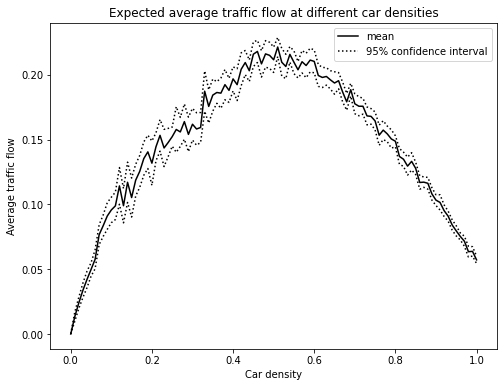

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as sts

plt.figure(figsize=(8, 6))
plt.title('Expected average traffic flow at different car densities')
plt.xlabel('Car density')
plt.ylabel('Average traffic flow')
flow_mean = np.mean(average_flows, axis=1)
std_err = sts.sem(average_flows, axis=1)
plt.plot(densities, flow_mean, 'k-', label='mean')
plt.plot(densities, flow_mean - 1.96 * std_err, 'k:',
         label='95% confidence interval')
plt.plot(densities, flow_mean + 1.96 * std_err, 'k:')
plt.legend()
plt.show()